In [172]:
from filmscope.datasets import FSDataset
from filmscope.recon_util import get_sample_information, get_ss_volume_from_dataset, get_all_sample_names
from filmscope.calibration import CalibrationInfoManager
from filmscope.config import path_to_data
from filmscope.reconstruction import generate_config_dict
from filmscope.util import play_video
from matplotlib import pyplot as plt
import torch
import numpy as np
import os 
import cv2 

In [173]:
get_all_sample_names()

['fluoro_bright', 'fluoro_bright_calib2']

In [178]:
#all_info = generate_config_dict("2", "combo_fluoro_bright", downsample=4)
image_numbers = [13, 14, 15, 16, 
                 19, 20, 21, 22,
                 25, 26, 27, 28,
                 31, 32, 33, 34]
# make sure both sets include the reference camera
fluoro_cameras = [13, 15, 20, 22, 25, 27, 32, 34, 21]
bright_cameras = [14, 16, 19, 21, 26, 28, 31, 33]

image_numbers = bright_cameras
sample_name = "fluoro_bright"#_calib2"
gpu_number="0" 
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_number

use_neptune = False 
all_info = generate_config_dict(sample_name=sample_name, gpu_number=gpu_number, downsample=5,
                                   camera_set="custom", use_neptune=use_neptune,
                                   #crop_name="fluoro_patch",
                                   custom_image_numbers=image_numbers,
                                   run_args={"iters": 1000, "batch_size": 16, "num_depths": 64,
                                             "display_freq": 50, "unet_layers": 4,
                                             "unet_layer_channels": [8, 16, 16, 16, 16],
                                             "lr": 1e-3},
                                   loss_weights={"smooth": 0.35})
#all_info = generate_config_dict("2", "rat_skull_12_11", downsample=4)
info = all_info["sample_info"]
calib_manager = CalibrationInfoManager(path_to_data + info["calibration_filename"])


In [157]:
#info["image_filename"] = "/graph_03_20241226_150713_052.nc"
#info["image_filename"] = "/graph_01_20241226_150618_331.nc"
#info["image_filename"] = "/bright_signal_2_20241226_150105_626.nc"

In [179]:
dataset = FSDataset(
    path_to_data + info["image_filename"],
    path_to_data + info["calibration_filename"],
    info["image_numbers"],
    info["downsample"],
    ensure_grayscale=False,
    ref_crop_center=info["ref_crop_center"],
    crop_size=info["crop_size"],
    height_est=info["height_est"]
    )

loading images: 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]


In [176]:
# just because we had to include the reference camera 
#dataset.images[dataset.reference_index] = torch.zeros_like(dataset.images[dataset.reference_index])

In [189]:
dr = info["depth_range"]
depth_values = torch.linspace(dr[0], dr[1] + 4, 100).cuda()
volume = get_ss_volume_from_dataset(dataset, batch_size=5, depth_values=depth_values,
                                    get_squared=False).squeeze()

In [190]:
video = volume.cpu().permute((1, 2, 3, 0)).numpy()
video = video / np.max(video)

[]

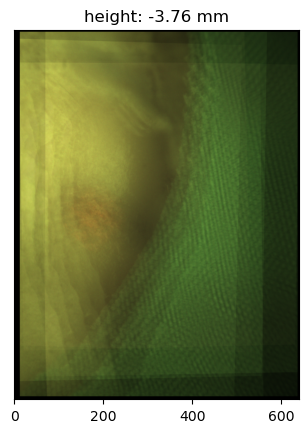

In [191]:
idx = 2
plt.imshow(video[idx])#, 100:-100, 100:-100] * 1.7)
plt.title("height: {:.2f} mm".format(float(depth_values[idx])))
ax = plt.gca() 
#ax.set_xticks([])
ax.set_yticks([])

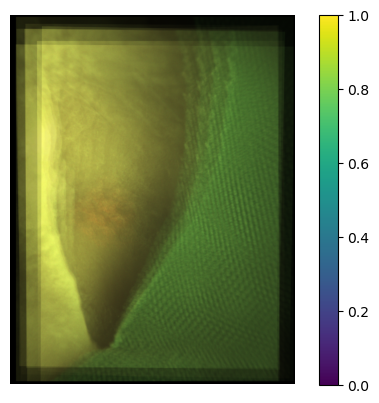

In [188]:
play_video(video)#[:, 220:450, 500:750])

In [132]:
video_gray = np.mean(video, axis=-1)
lap_video = np.zeros_like(video_gray)
for i, frame in enumerate(video_gray):
    lap_video[i] = np.abs(cv2.Laplacian(frame, cv2.CV_16S, ksize=5))

KeyboardInterrupt: 

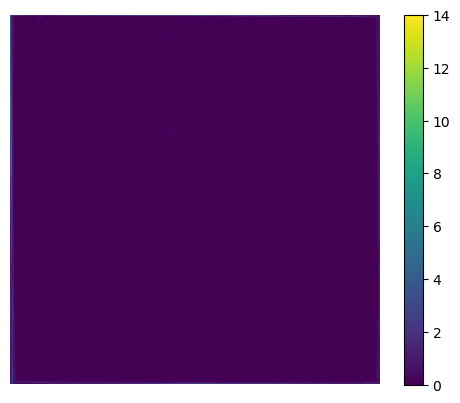

In [133]:
play_video(lap_video)

Text(0.5, 1.0, 'Predicted Depth using Laplacian Focus Score (mm)')

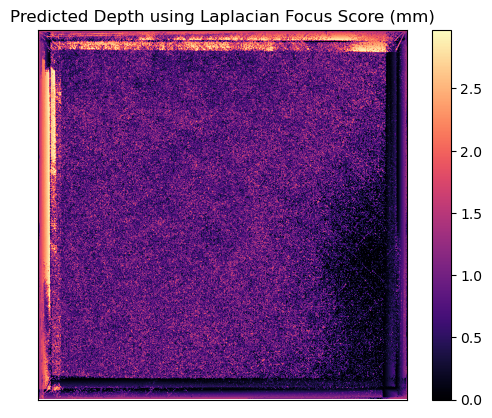

In [134]:
b = np.argmax(lap_video, axis=0)
dv = depth_values.cpu().numpy()
b = b / len(dv) * (np.max(dv) - np.min(dv))
plt.imshow(b, cmap='magma')
plt.colorbar()
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("Predicted Depth using Laplacian Focus Score (mm)")

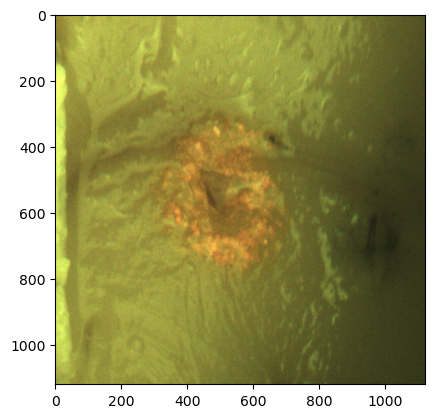

In [135]:
plt.imshow(dataset.images[5].cpu().permute(1, 2, 0).to(torch.uint8))

In [ ]:
folder = path_to_data

In [192]:
# save volume as numpy array temporarily
np.save(path_to_data + '/combo_video.npy', (video / np.max(video) * 255).astype(np.uint8))

1.0

NameError: name 'manager' is not defined

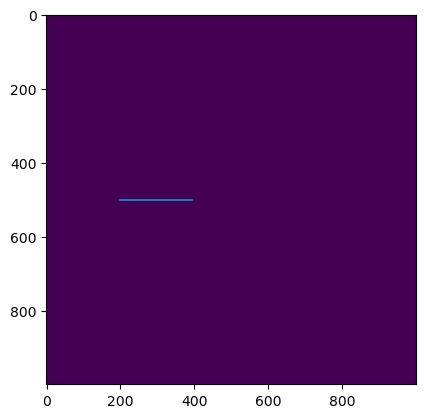

In [216]:
from filmscope.calibration import Filmscope_System
system = Filmscope_System(path_to_data + info["calibration_filename"])
system.calib_manager.vertex_spacing_m = 2e-3
mag = system.get_magnification_at_plane(camera_number=21, plane_mm=0, dim=0)

dist = 1e-3 
dist = dist * mag / system.calib_manager.pixel_size

a = np.zeros((1000, 1000))
plt.imshow(a)

plt.plot([200, 200 + dist], [500, 500])

In [212]:
dist

0.001